In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5

***
## load and prepare data

In [4]:
!ls ../data/processed/dsv02

dataset-metadata.json  test.parquet  train.parquet


In [5]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
train = train.reset_index()

del train_labels
gc.collect()

36

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 2112,
    'verbosity': 0,
    'first_metric_only': True,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.2,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 1000,
    'path_smooth': 10,
    'max_bin': 255,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold")
        valid_df = dataframe.query("fold == @fold")
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=3000,
            callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(100)],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
            
        models.append(model)
        del train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
glob("../data/processed/cv*.parquet")

['../data/processed/cv1.parquet',
 '../data/processed/cv2.parquet',
 '../data/processed/cv4.parquet',
 '../data/processed/cv0.parquet',
 '../data/processed/cv3.parquet']

############################### repeated cross-validation step: 1/5 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Traini

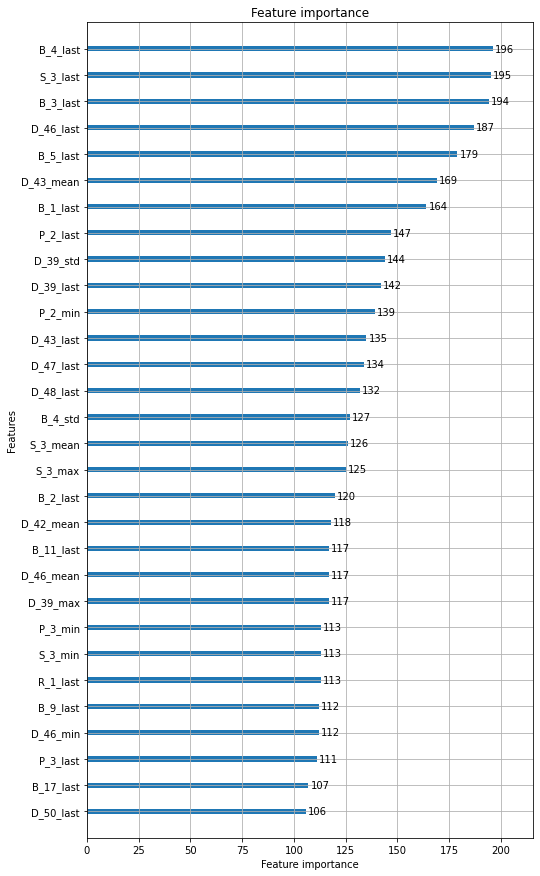

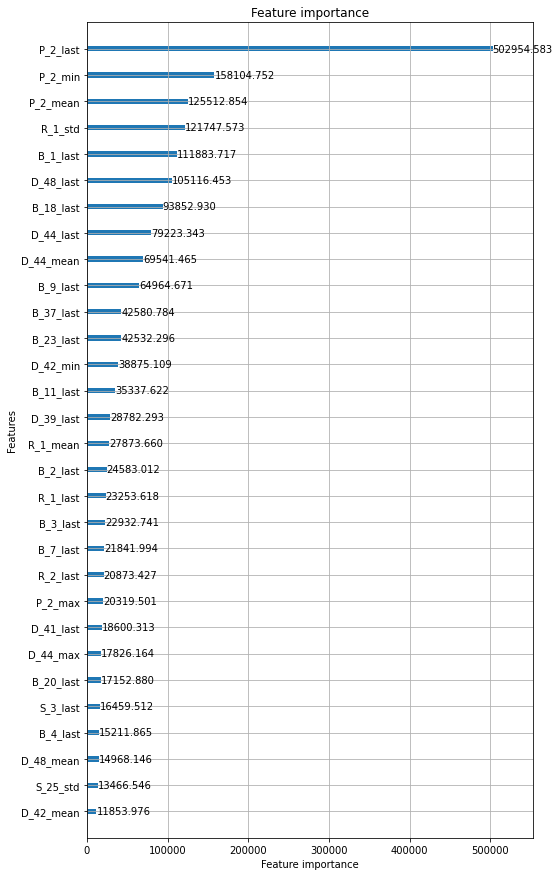

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.767233	valid_0'

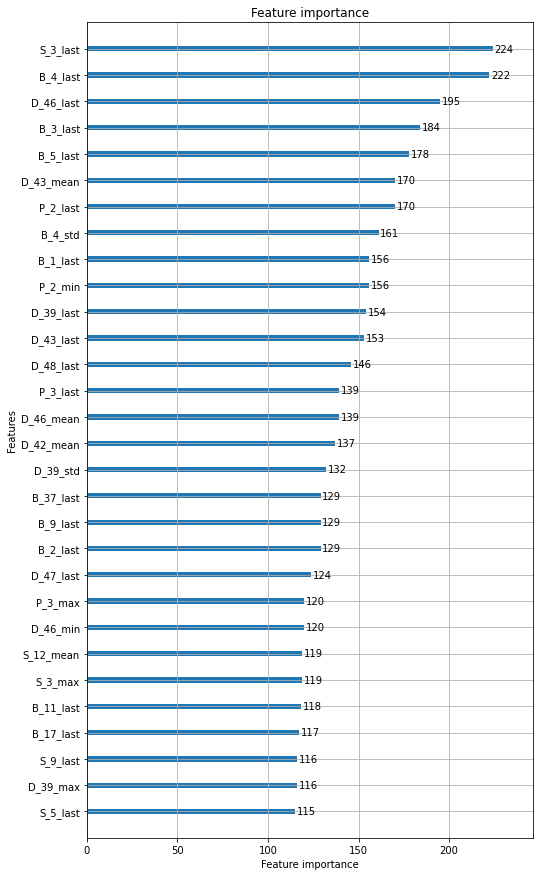

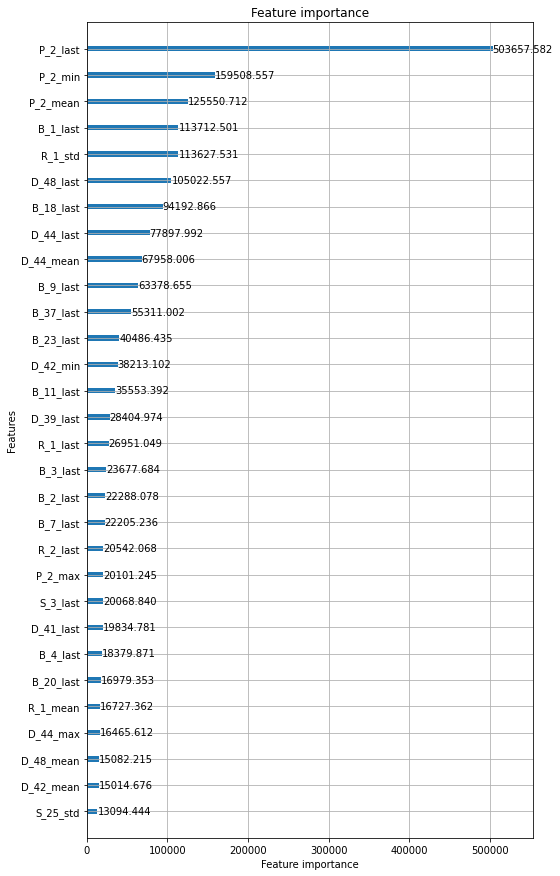

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.761704	valid_0'

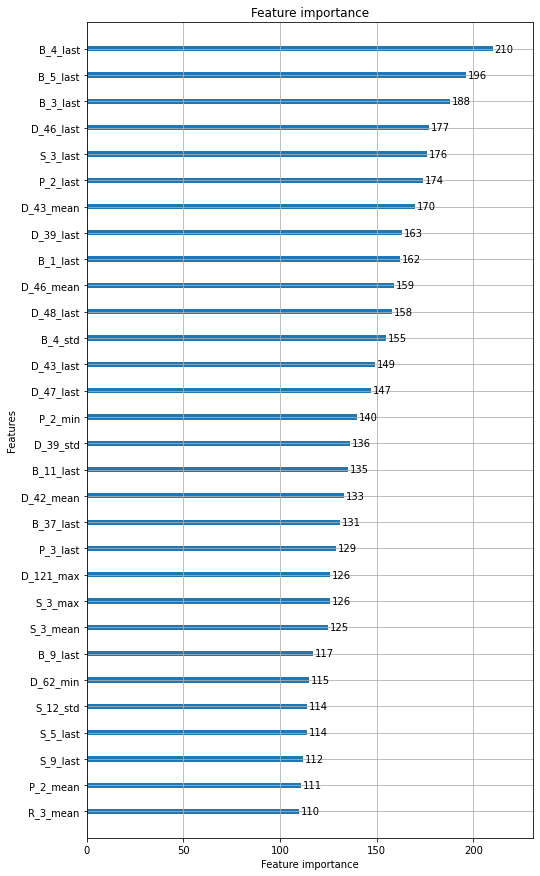

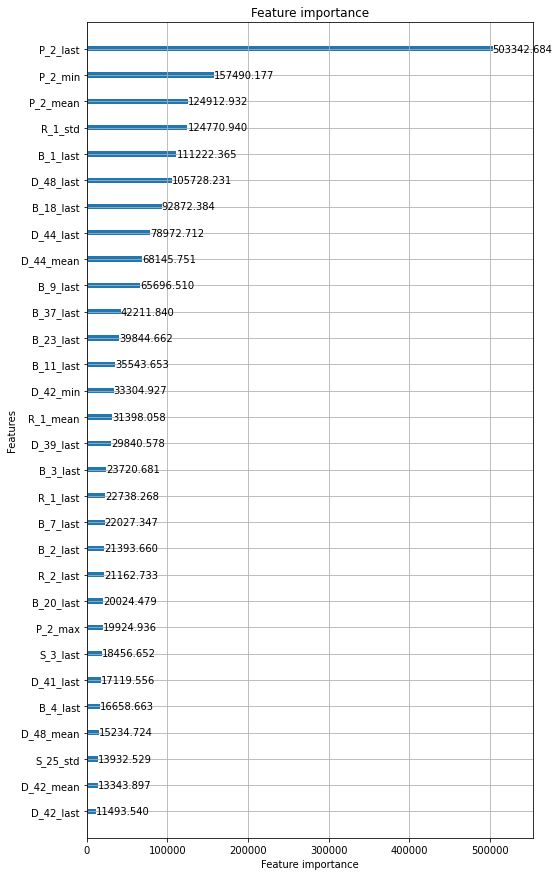

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.765648	valid_0'

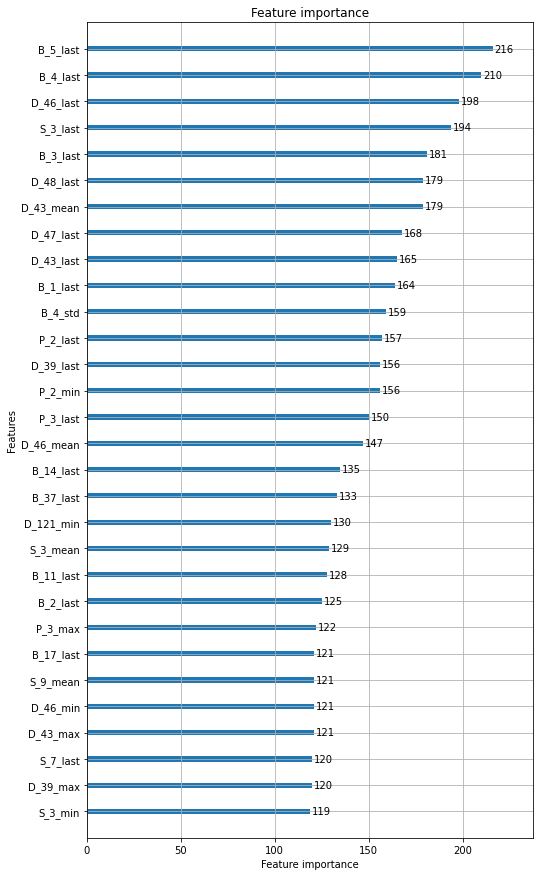

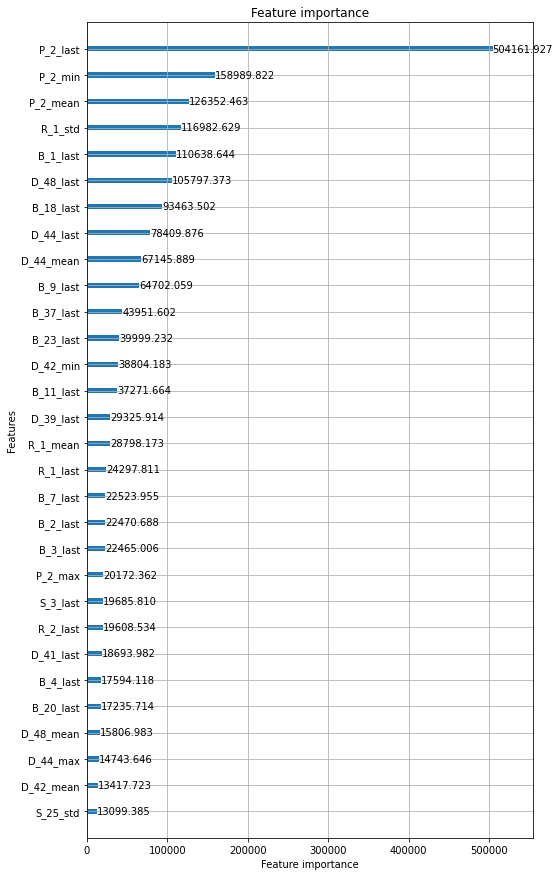

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.770442	valid_0'

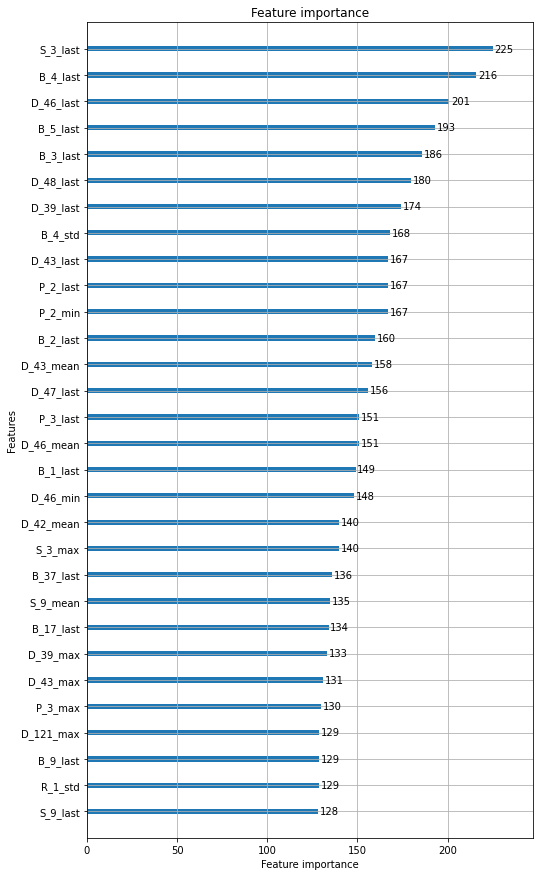

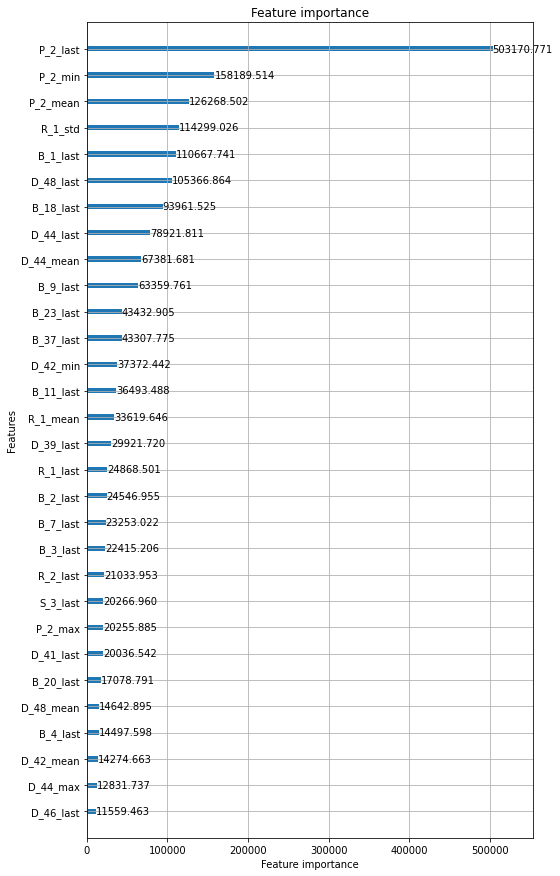

Training time: 10.223361007372539 min.
OOF recall_at4: 0.6613424445416906
OOF normalized_gini: 0.9234764487799739
OOF competition metric: 0.7924094466608322
############################### repeated cross-validation step: 2/5 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met 

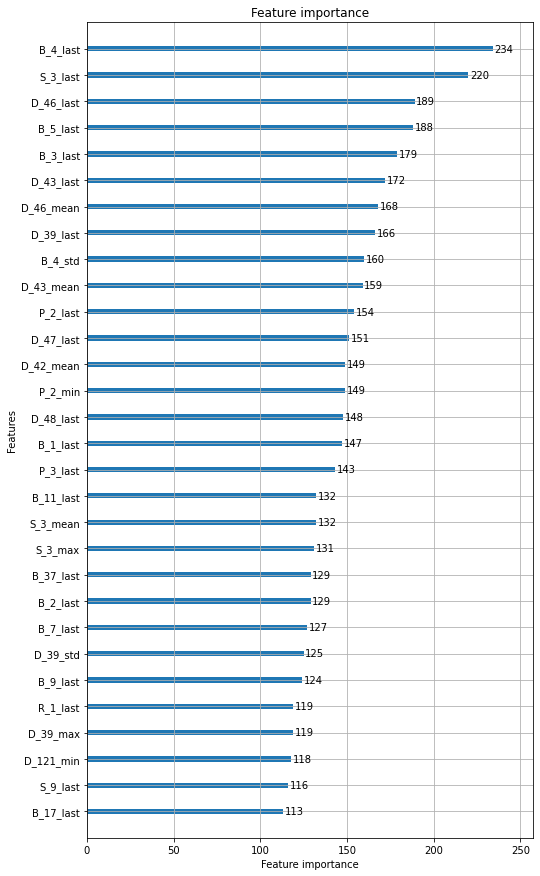

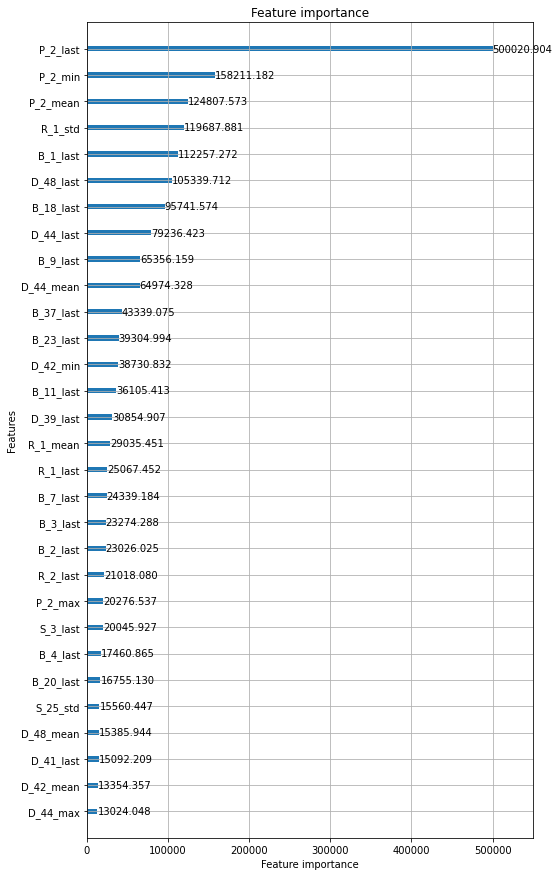

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.765155	valid_0'

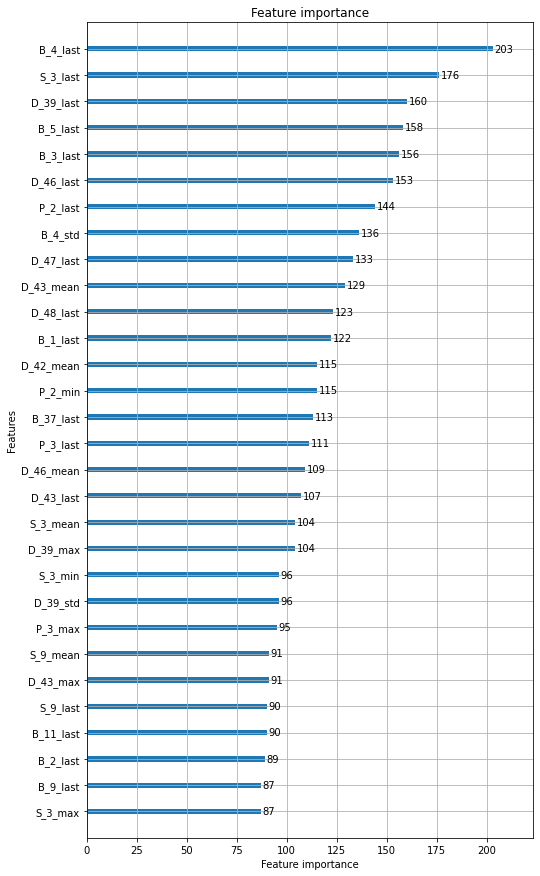

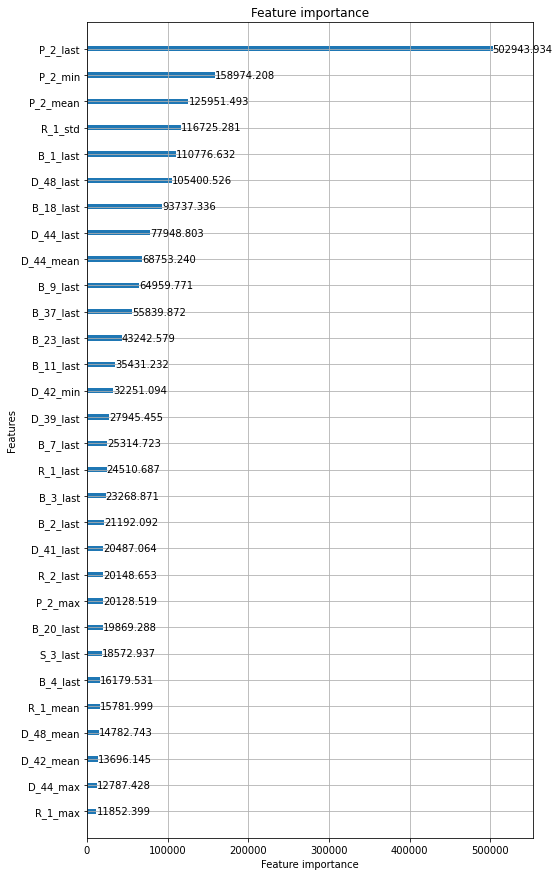

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.761328	valid_0'

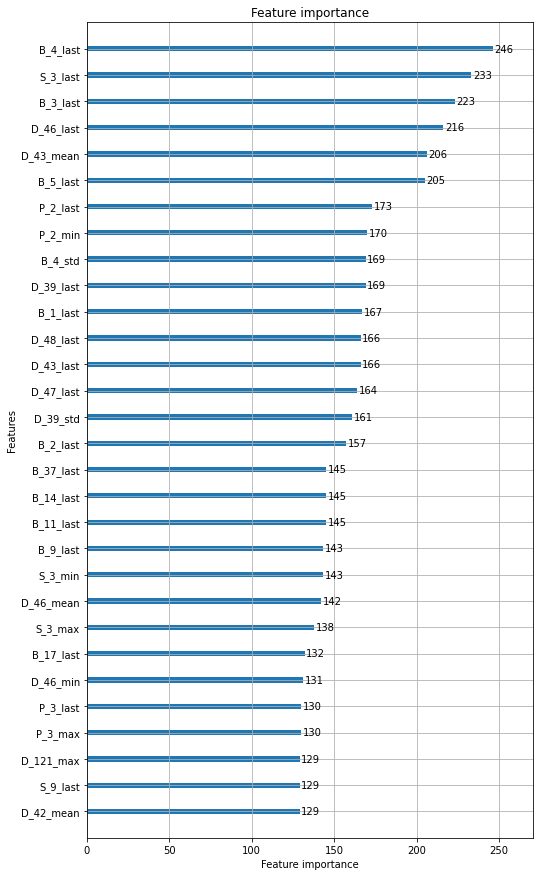

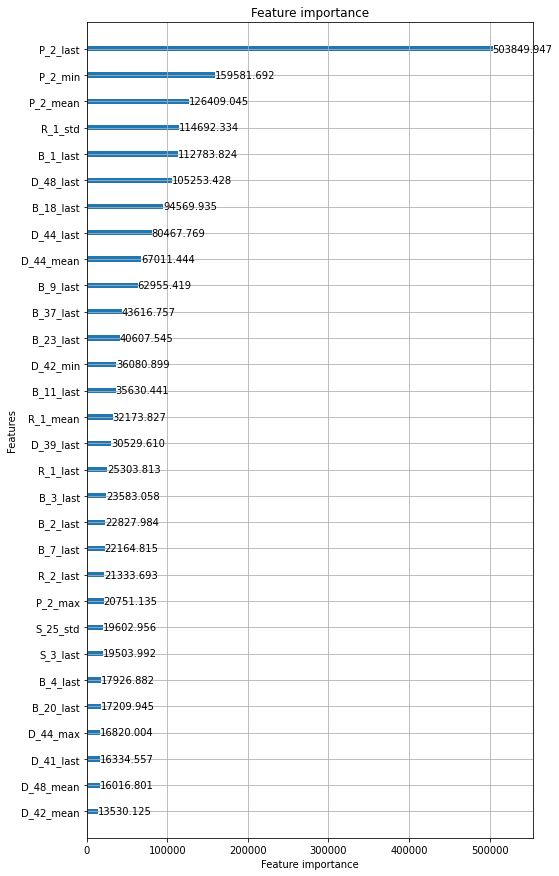

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.767976	valid_0'

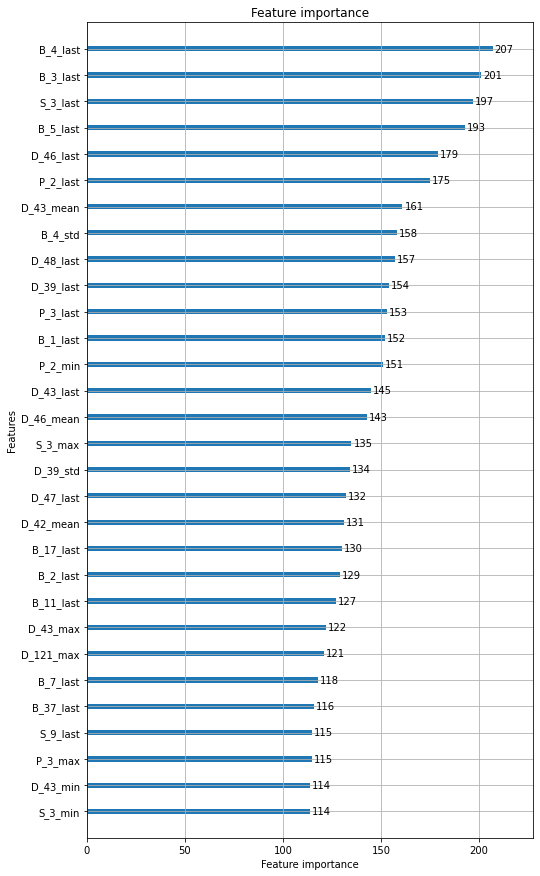

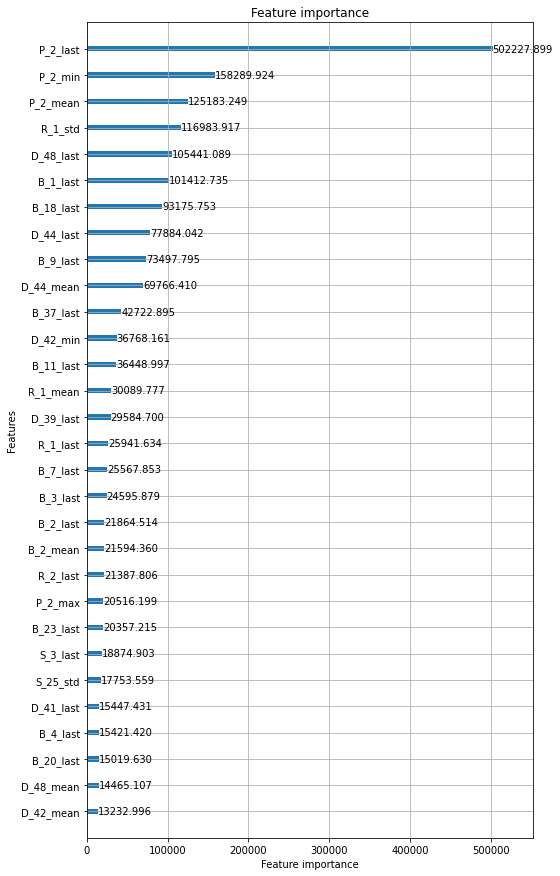

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.769769	valid_0'

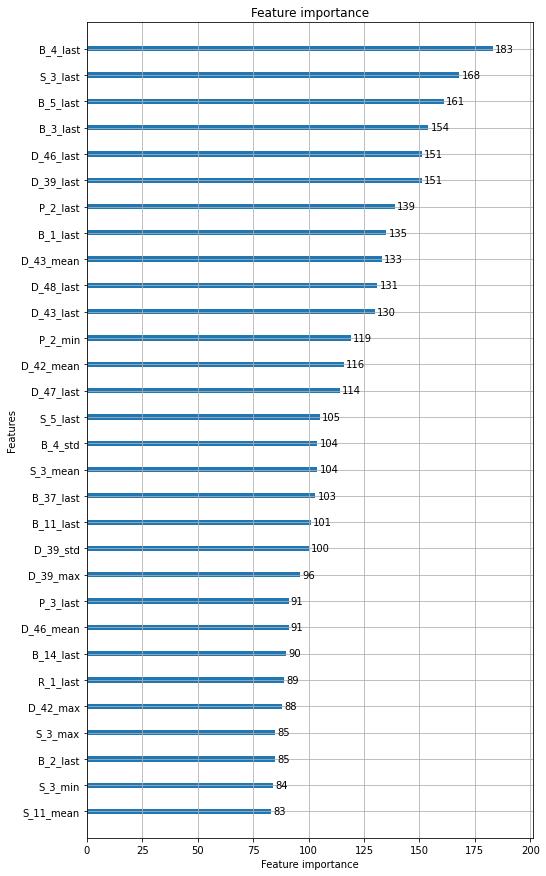

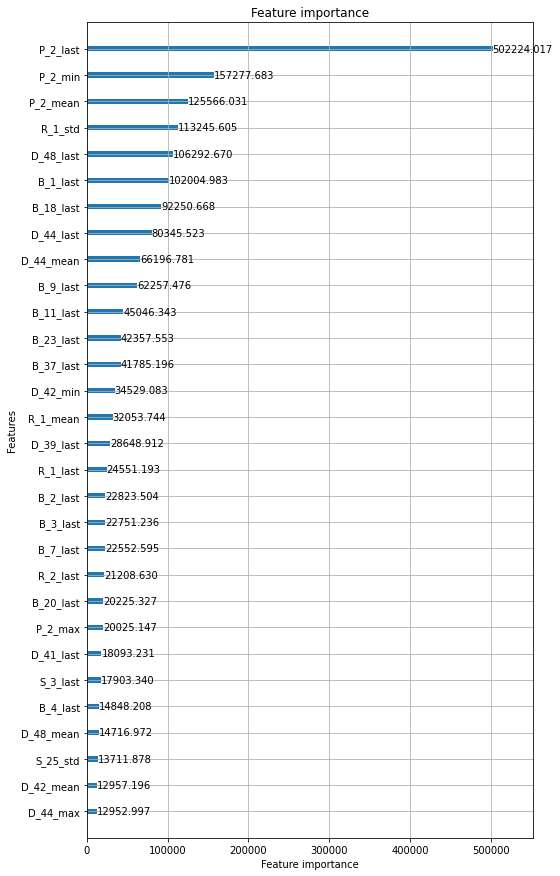

Training time: 9.583579830328624 min.
OOF recall_at4: 0.6618894536641196
OOF normalized_gini: 0.9233178877638165
OOF competition metric: 0.7926036707139681
############################### repeated cross-validation step: 3/5 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met n

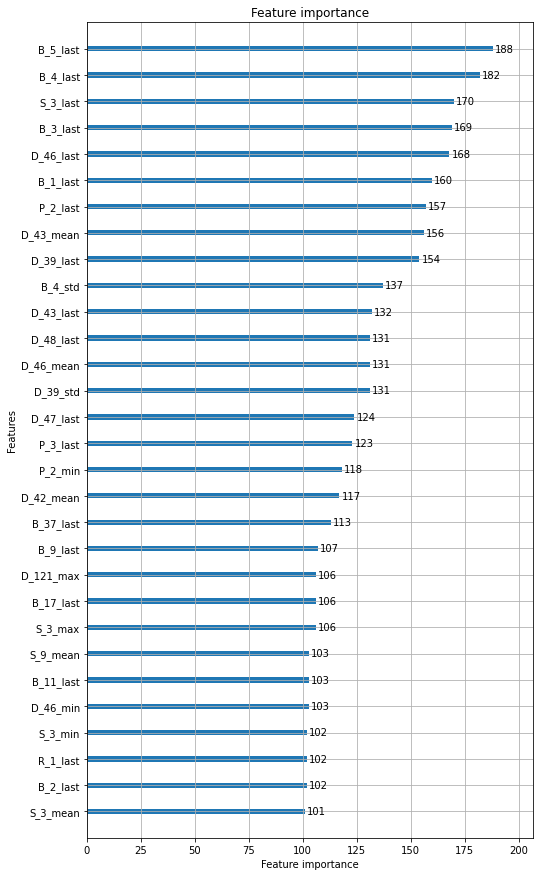

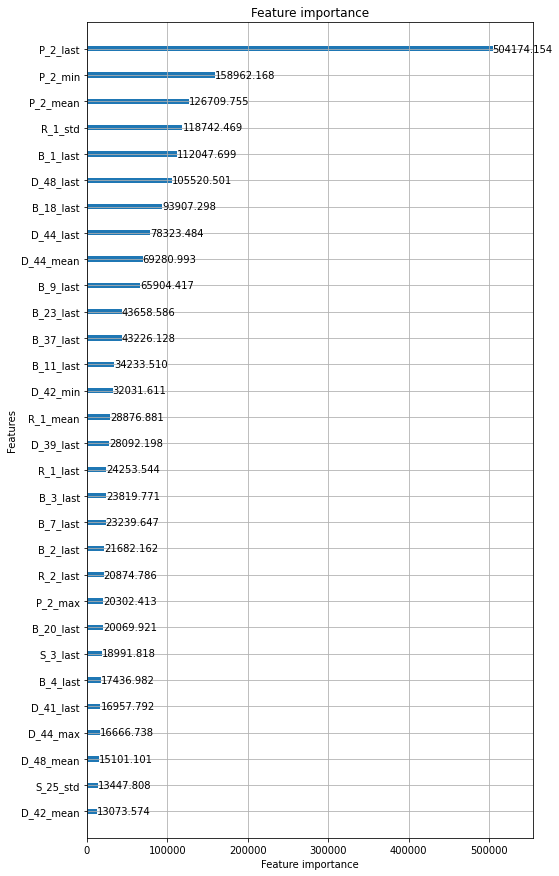

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.762939	valid_0'

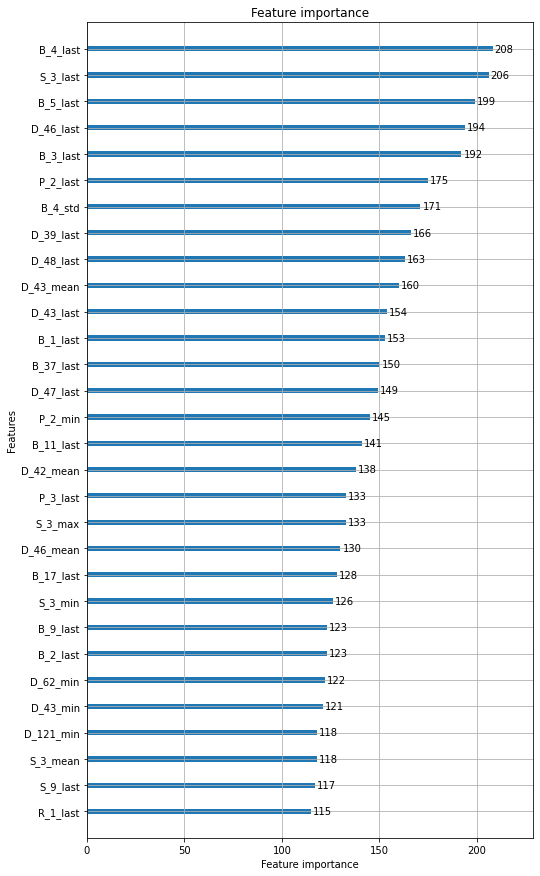

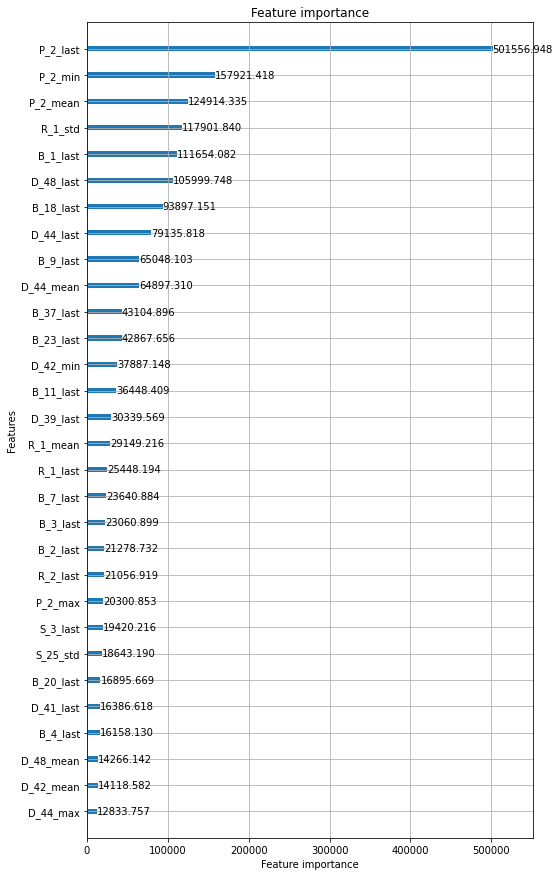

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.768002	valid_0'

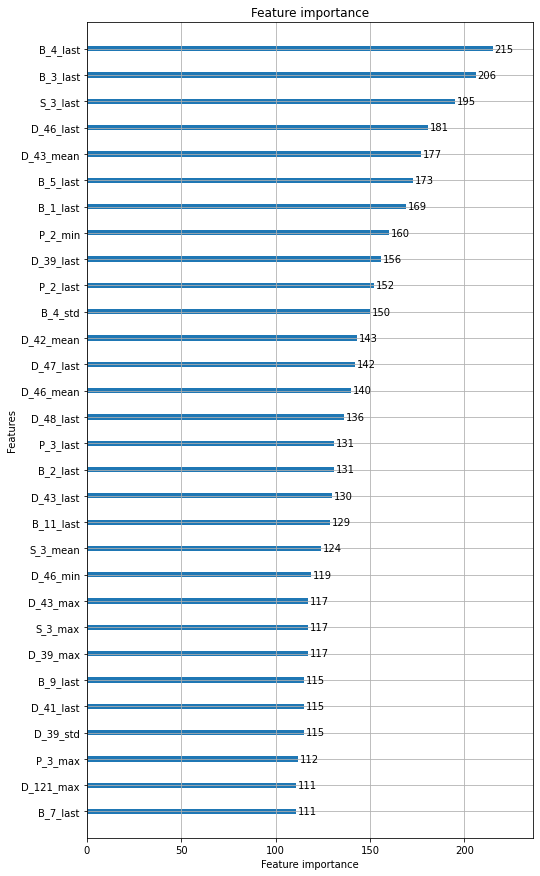

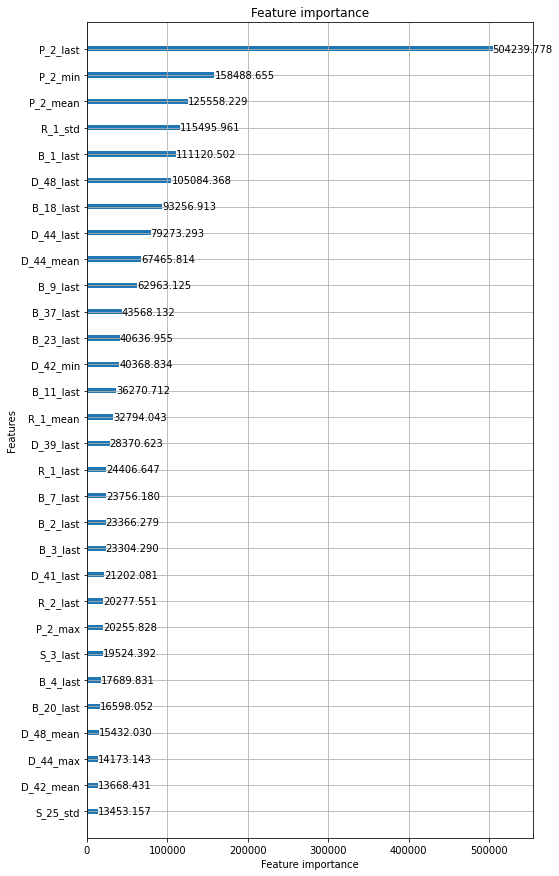

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.775052	valid_0'

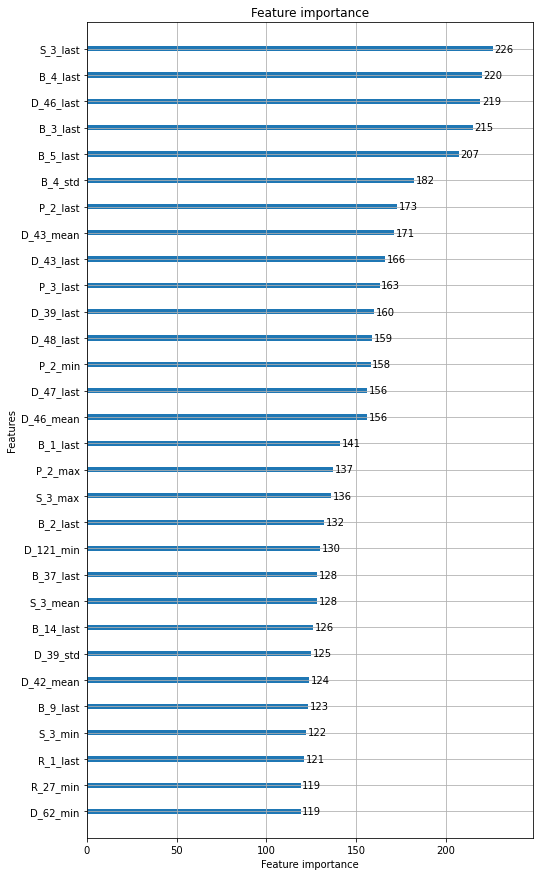

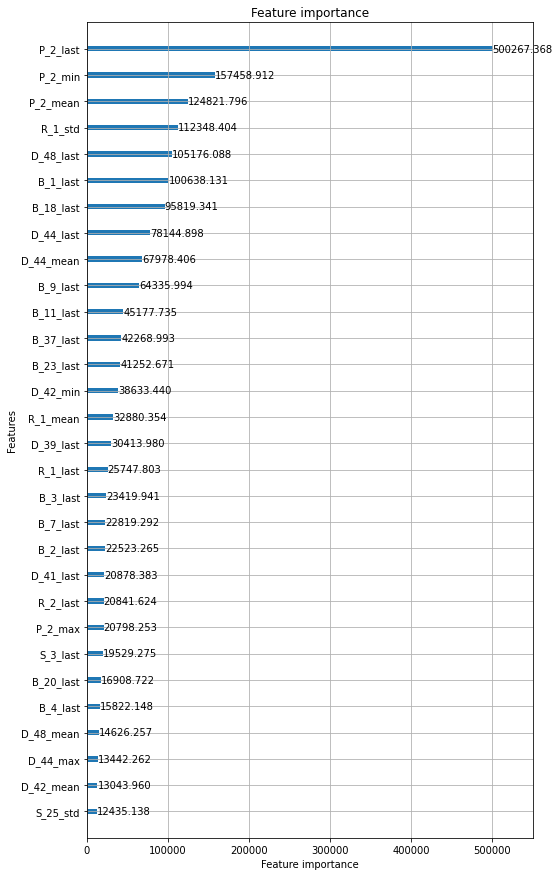

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.767843	valid_0'

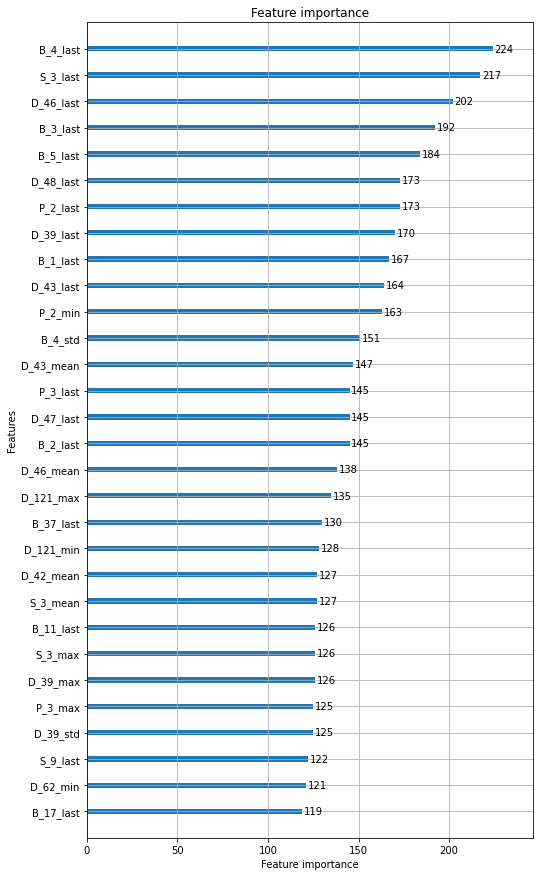

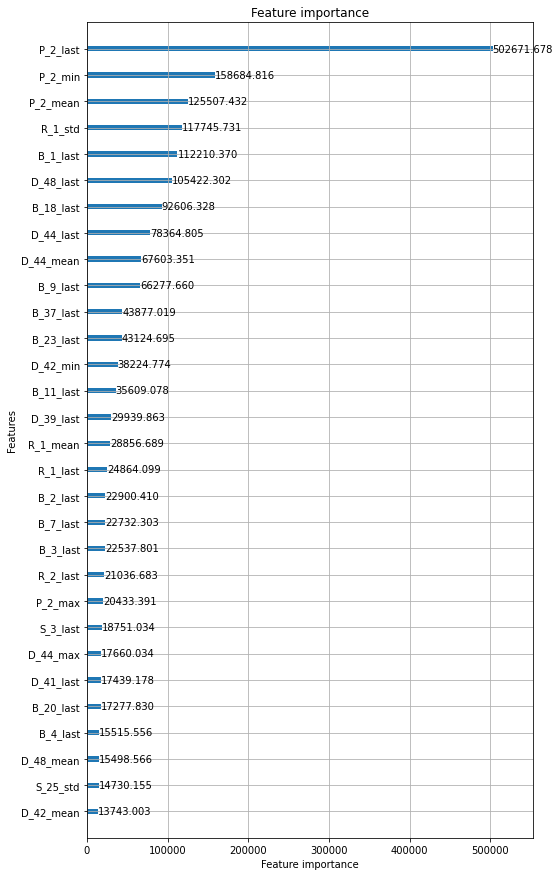

Training time: 10.03720544576645 min.
OOF recall_at4: 0.662310229912142
OOF normalized_gini: 0.9236666829015945
OOF competition metric: 0.7929884564068682
############################### repeated cross-validation step: 4/5 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met ne

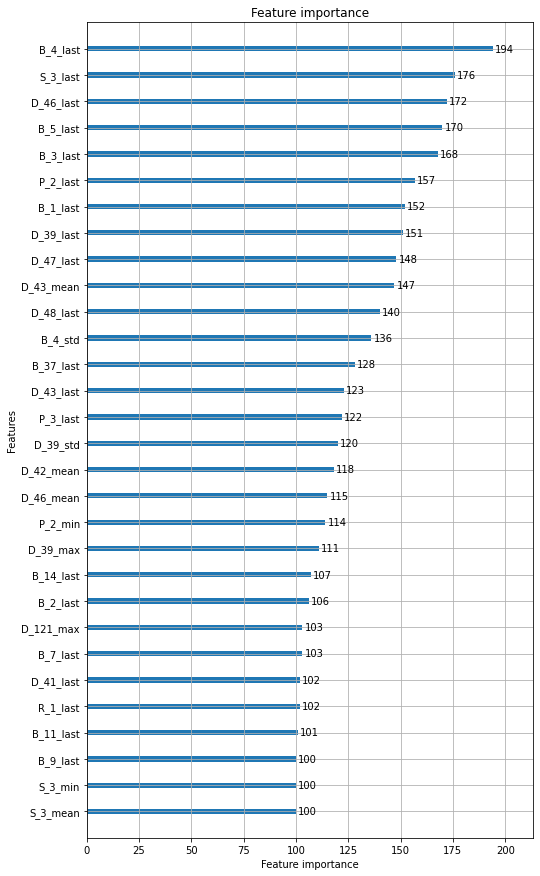

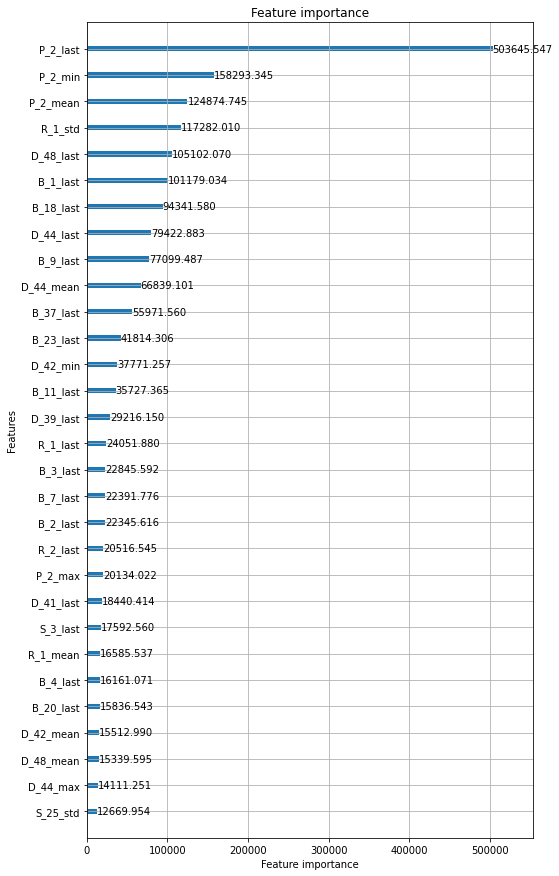

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.768348	valid_0'

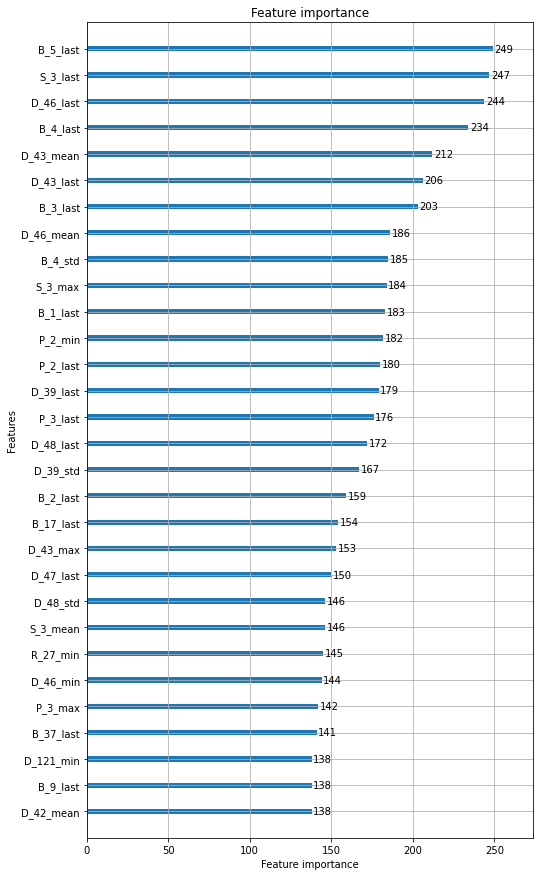

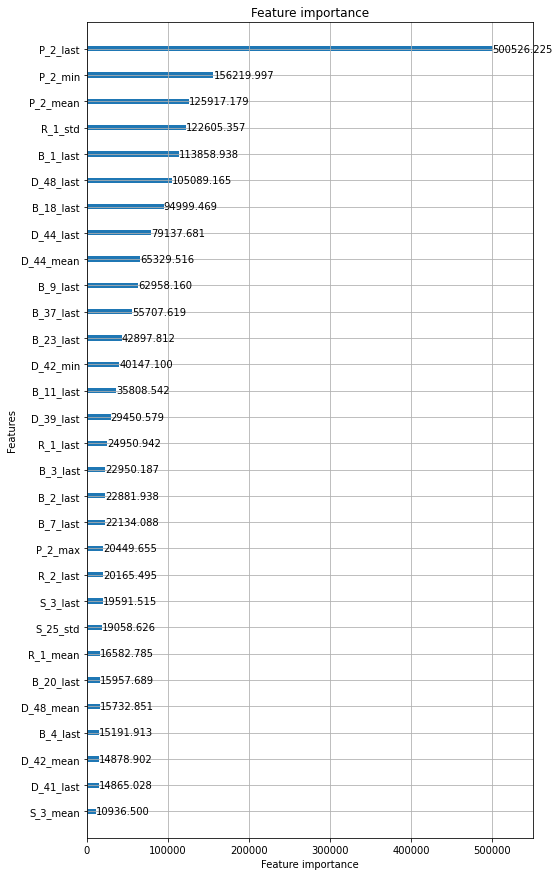

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.769101	valid_0'

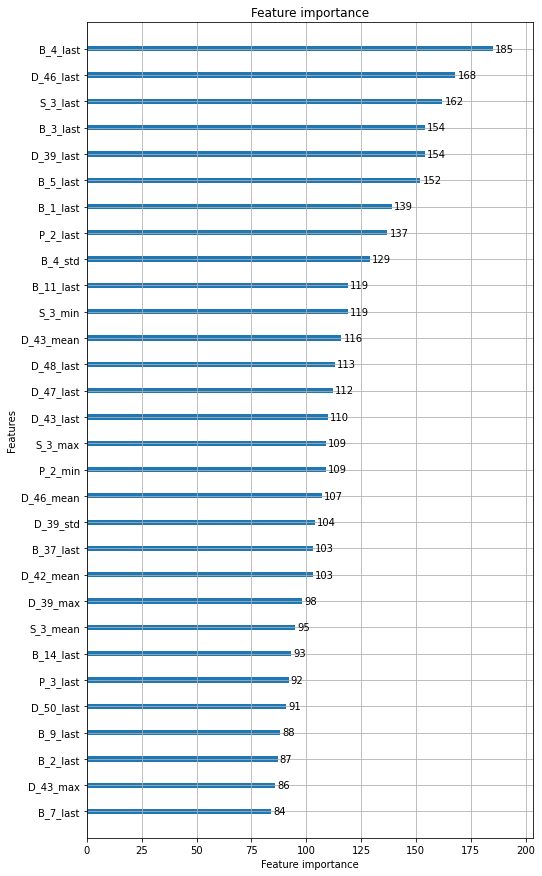

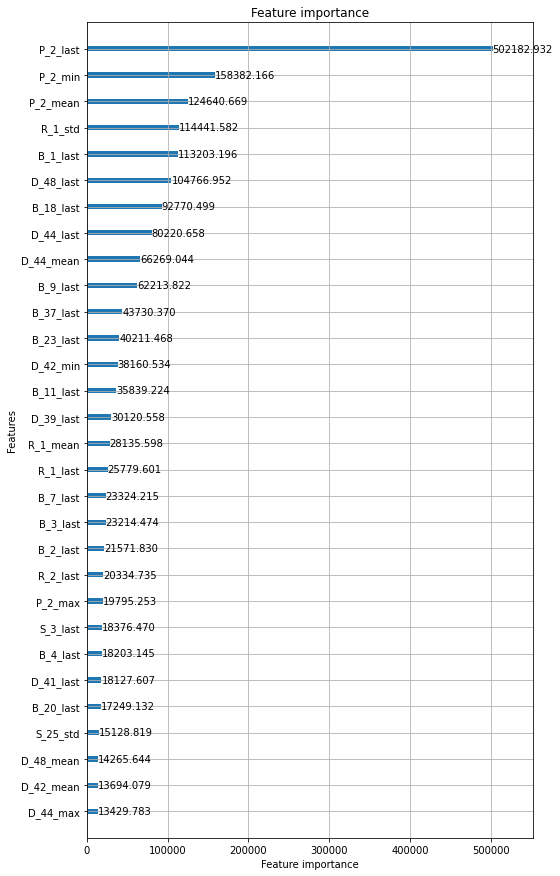

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.767241	valid_0'

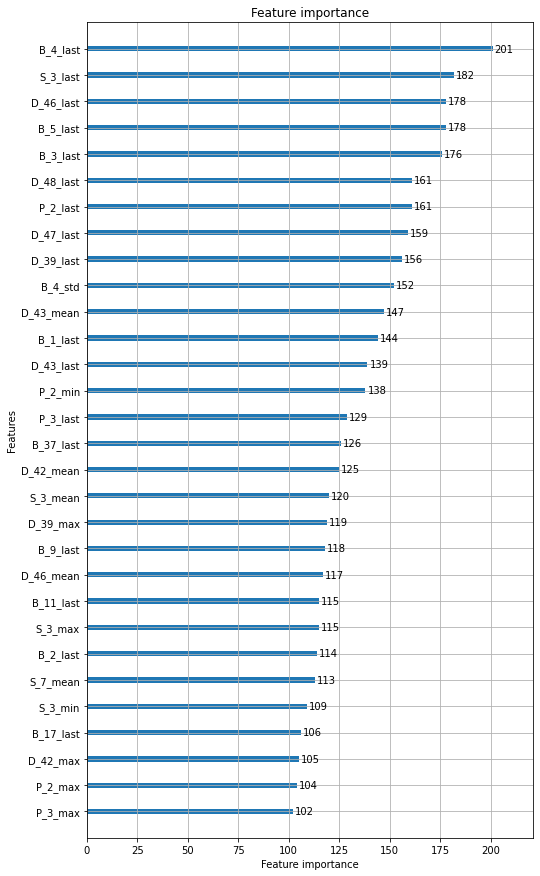

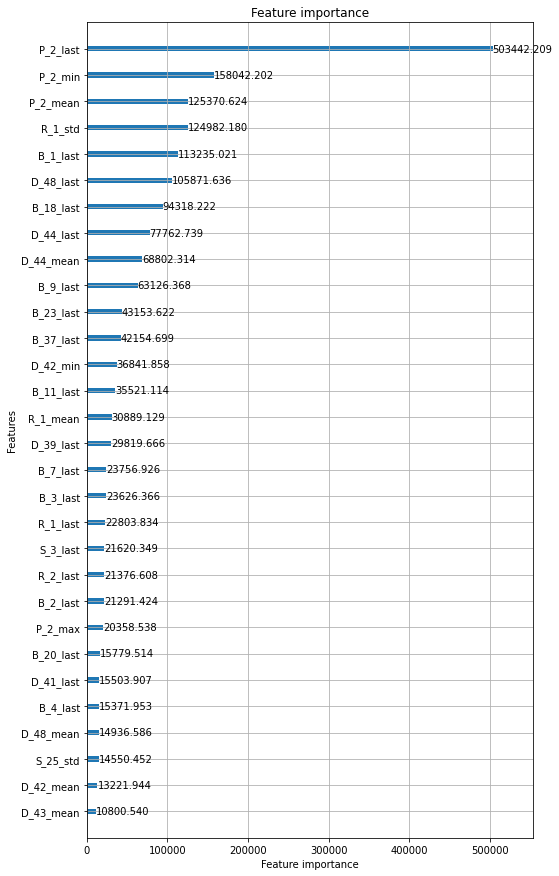

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.764663	valid_0'

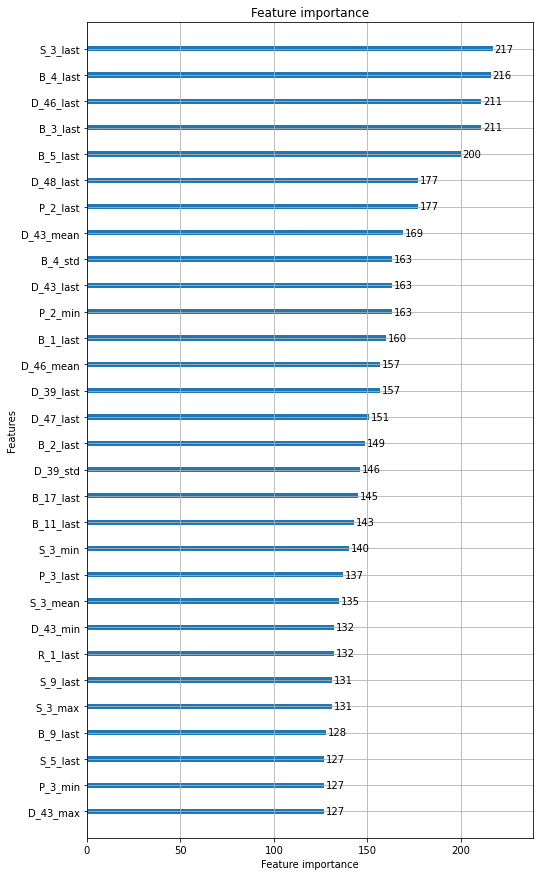

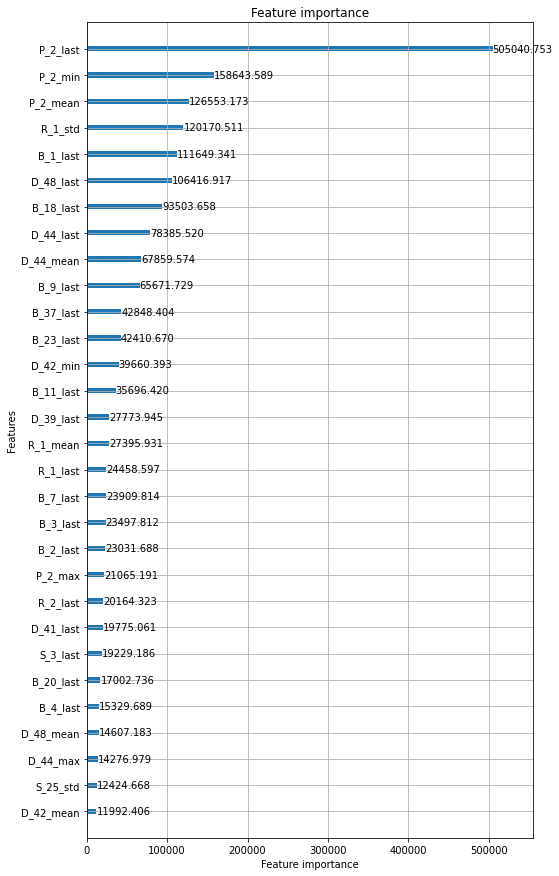

Training time: 9.867527051766713 min.
OOF recall_at4: 0.6609637459184704
OOF normalized_gini: 0.9233561091027793
OOF competition metric: 0.7921599275106248
############################### repeated cross-validation step: 5/5 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met n

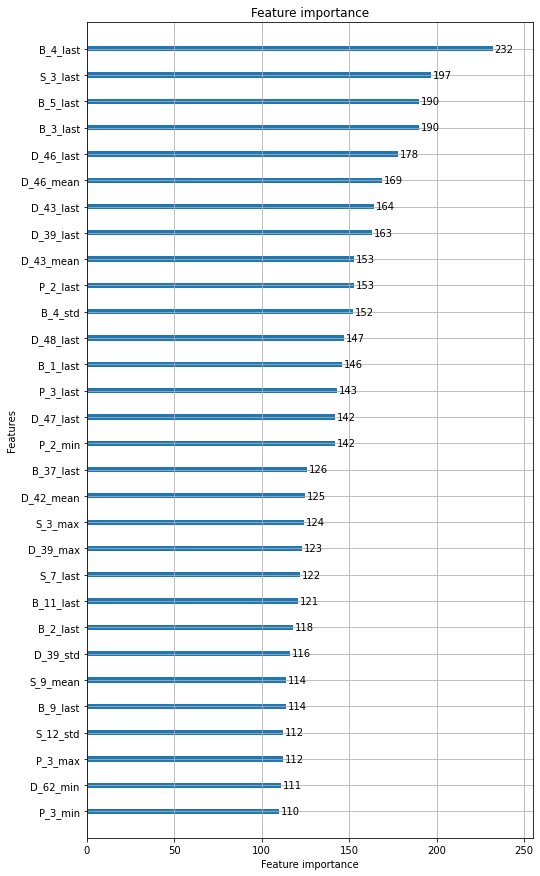

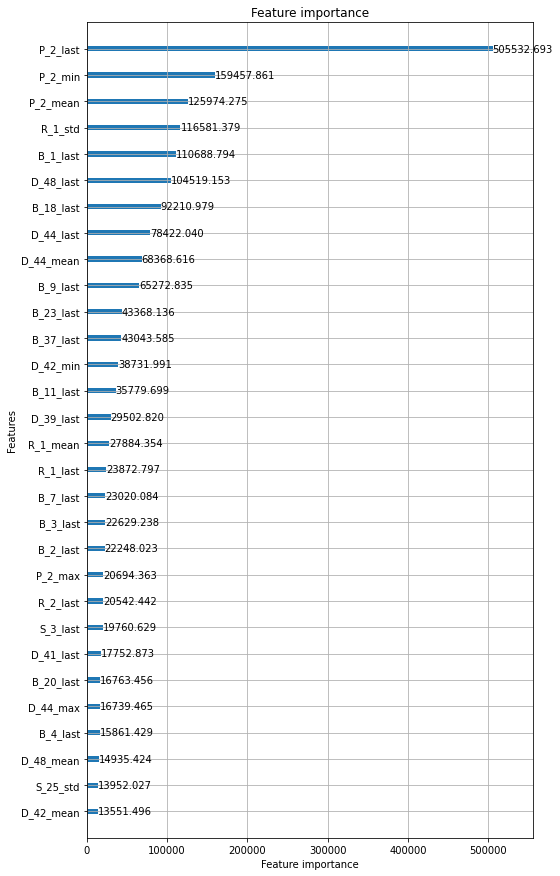

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.770555	valid_0'

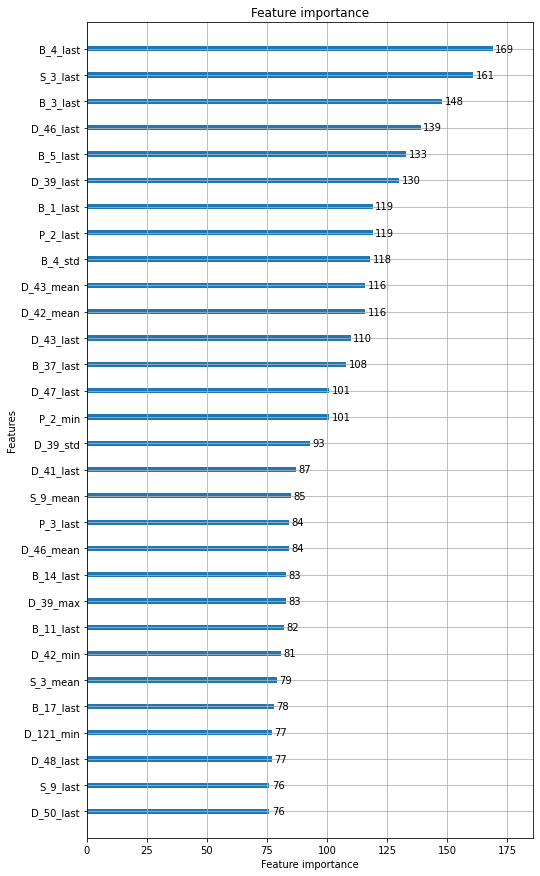

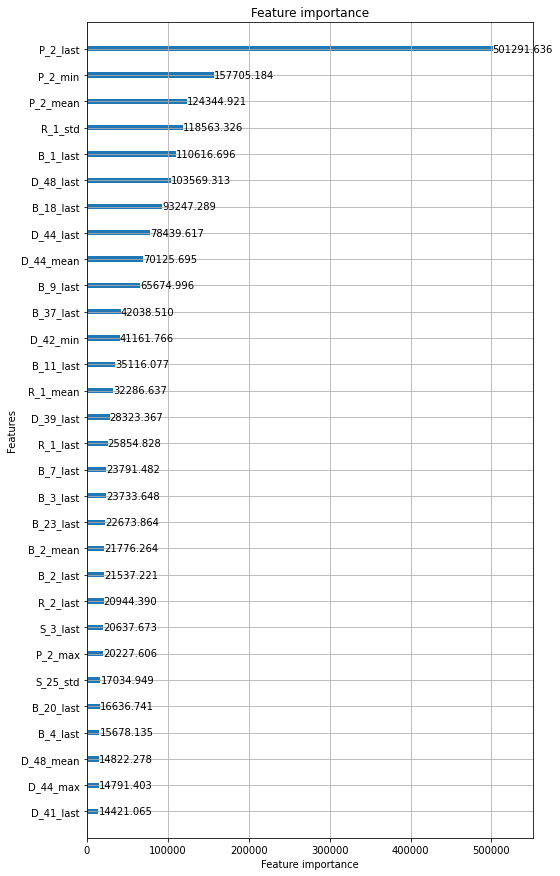

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.764375	valid_0'

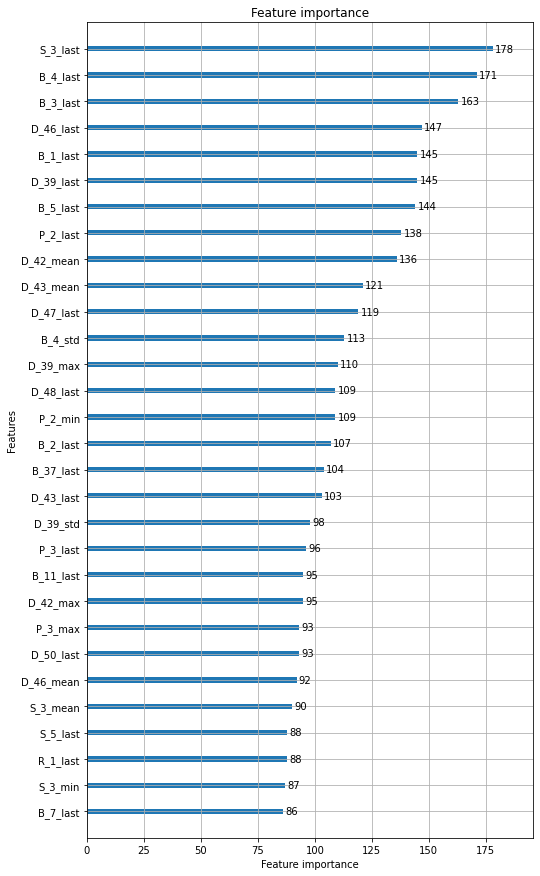

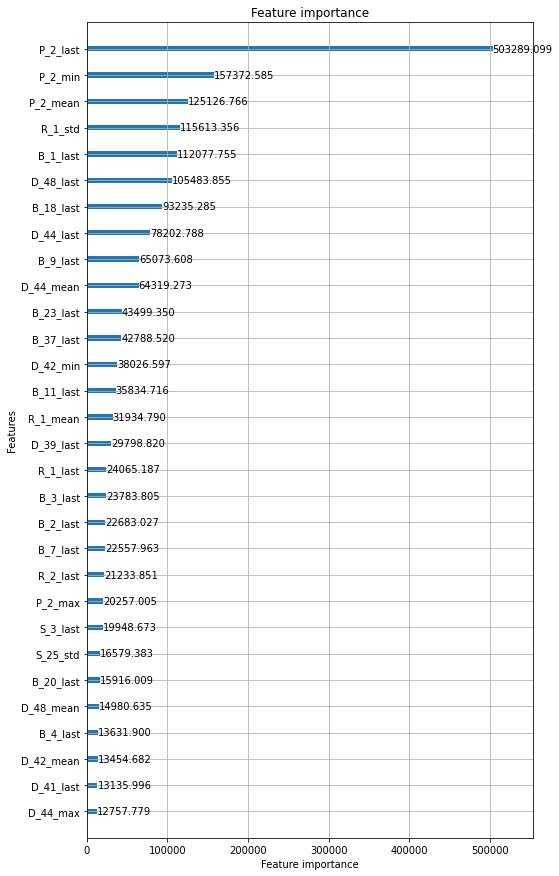

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.765339	valid_0'

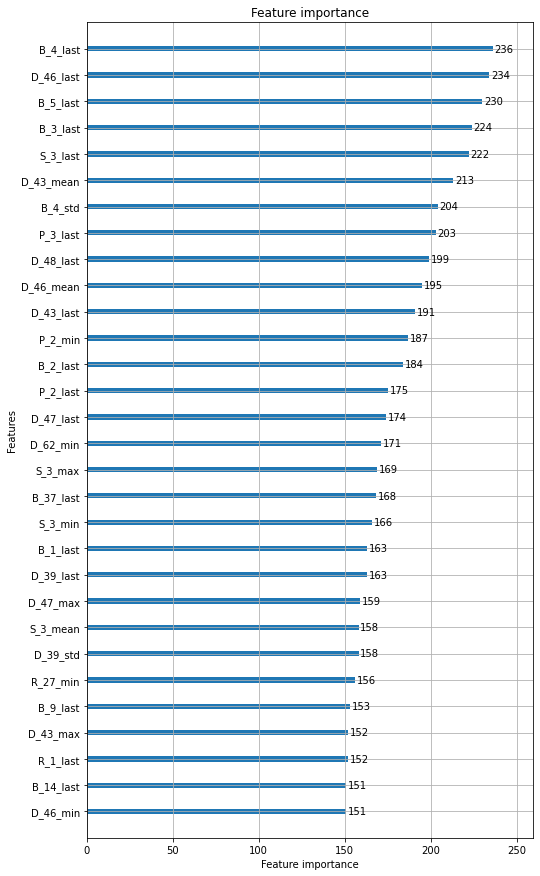

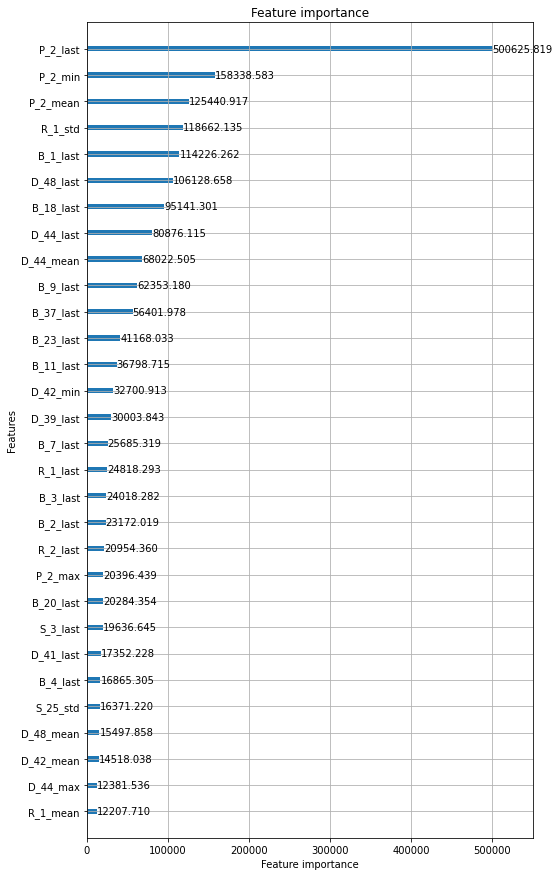

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.763811	valid_0'

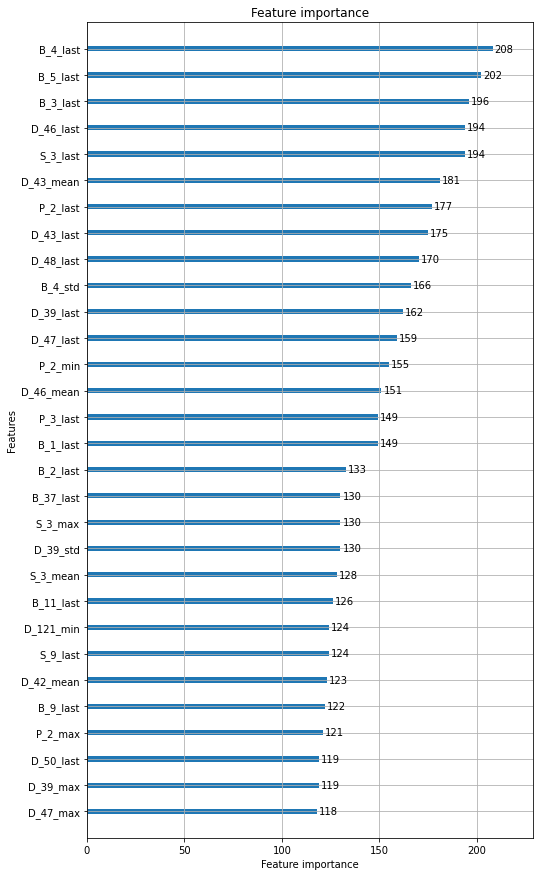

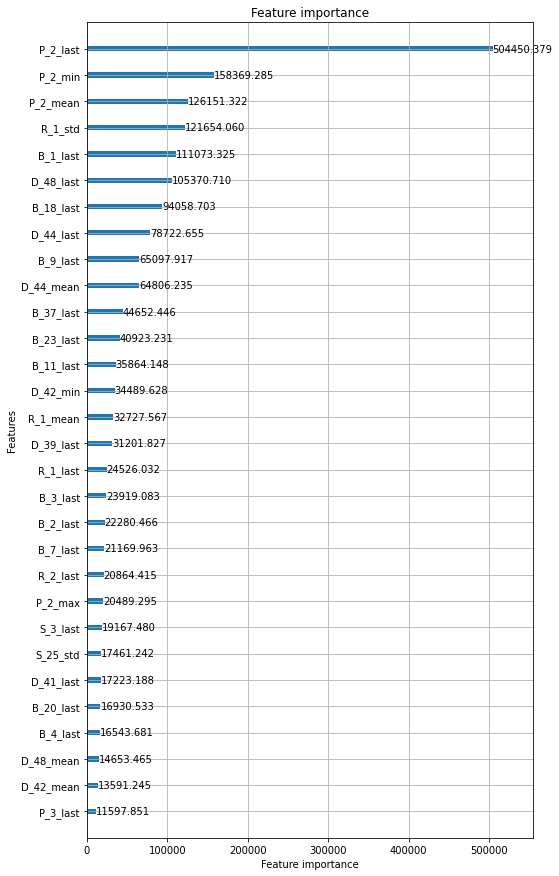

Training time: 9.652712392807008 min.
OOF recall_at4: 0.6630423805837008
OOF normalized_gini: 0.9233082380376489
OOF competition metric: 0.7931753093106748
CPU times: user 5h 15min 53s, sys: 1min 11s, total: 5h 17min 5s
Wall time: 58min 18s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{5} ".center(100, "#"))
    
    if "fold" in train.columns:
        train.drop("fold", axis=1, inplace=True)
    folds = pd.read_parquet(f'../data/processed/cv{repetition}.parquet')
    train = pd.merge(train, folds, how="inner", on="customer_ID")
    
    tic = time.time()
    models,oof = train_models(train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
          
    all_models.extend(models)
    all_oof_dfs.append(oof)
          
    del folds; gc.collect()

In [31]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.661342,0.923476,0.792409
1,0.661889,0.923318,0.792604
2,0.662310,0.923667,0.792988
3,0.660964,0.923356,0.792160
4,0.663042,0.923308,0.793175



mean:


recall_at4    0.661910
gini          0.923425
metric        0.792667
dtype: float64


std:


recall_at4    0.000816
gini          0.000151
metric        0.000415
dtype: float64

In [13]:
del train
gc.collect()

23

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [36]:
%%time
for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    imin = repetition*5
    imax = (repetition+1)*5
    
    test["prediction"] = make_predictions(test, input_feats, all_models[imin:imax])
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-cv{repetition}.csv", index=False)

CPU times: user 53min 12s, sys: 2min 18s, total: 55min 30s
Wall time: 11min 21s


In [38]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = make_predictions(test, input_feats, all_models)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-all.csv", index=False)

CPU times: user 52min 55s, sys: 2min 13s, total: 55min 9s
Wall time: 11min


***